# Figure 5

Still a draft.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import datetime as dt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from scipy import stats
from dask.distributed import Client

In [3]:
# for gadi_jupyter
client = Client(n_workers=12)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38765 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:39609 Dashboard: /proxy/38765/status,Cluster Workers: 12 Cores: 24 Memory: 96.00 GiB


In [5]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EKEDir = 'processed_eke/'

In [6]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

# Load wind stress File and coarsen by a factor nn

In [36]:
# Load tau and coarsen by factor nn
nn=16
taufilename = HardDisk+'processed_tau/'+'tau_????.nc'
tau = xr.open_mfdataset(taufilename).tau.sel(lat=slice(-80,-30))
tau_coarse = tau.coarsen({"lon":nn,"lat":nn},boundary='trim').mean().load()
tau_coarse = tau_coarse.rename(tau.name+'_coarse'+str(nn))

tau_clim = tau_coarse.groupby('time.month').mean('time')
tau_deseas = (tau_coarse.groupby('time.month') - tau_clim).load()

#tau_cp = tau_coarse[6:-6] - tau_coarse.mean('time')

# Function to compute map of correlation coefficient at specified lag

In [8]:
def corrmap(jj, tau_cp, ekep):
    x1t = np.roll(tau_cp, jj,0)[jj:]
    x2t = ekep[jj:]

    nx = tau_cp.lon.size
    ny = tau_cp.lat.size
    corr_mat = np.zeros([ny,nx])
    for i in range(nx):
        for j in range(ny):
            if ~np.isnan(x1t[0,j,i]):
                corr_mat[j,i], sig = stats.pearsonr(x1t[:,j,i], x2t)

    return corr_mat

## Compute variance ratios from saved results

In [9]:
def CalcThisBox(latlon):

    ## Other things to set
    nfiles = 50
    nn=0
    start = dt.datetime(1980,1,1) ## start time for plotting
    end = dt.datetime(2014,12,31)

    ## plot EKE
    eke_results = []
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        ekefilename = HardDisk+EKEDir+'/eke_'+i00+'_????.nc'
        
        eke = xr.open_mfdataset(ekefilename).EKE
    
        eke = eke.sel(lon=slice(latlon['lon1'],latlon['lon2'])).sel(lat=slice(latlon['lat1'],latlon['lat2'])).mean('lon').mean('lat')
        eke_clim = eke.groupby('time.month').mean('time')
        eke_deseas = (eke.groupby('time.month') - eke_clim).load()
        #eke = eke.rolling(time=12,center=True).mean().load()    
        result = {'ii': ii,'eke': eke_deseas}
        eke_results.append(result)
    
        if ii==1:
            eke_sum = eke
        else:
            eke_sum = eke_sum + eke
        #print(ekefilename)
                        
    eke_sum = eke_sum.load()/nn
    eke_sum_clim = eke_sum.groupby('time.month').mean('time')
    eke_sum_deseas = (eke_sum.groupby('time.month') - eke_sum_clim).load()
    #ekep = eke_sum[6:-6] - eke_sum.mean()
    
    return eke_sum_deseas

## Now calculate correlation maps for each region

In [37]:
##
SEIO = {'lon1': -285, 'lon2': -240, 'lat1': -60, 'lat2':-40}
eke_deseas = CalcThisBox(SEIO)
corr_mat_SEIO_5 = corrmap(5, tau_deseas, eke_deseas)
corr_mat_SEIO_30 = corrmap(30, tau_deseas, eke_deseas)

In [39]:
SWPO = {'lon1': -215, 'lon2': -160, 'lat1': -60, 'lat2':-42}
eke_deseas = CalcThisBox(SWPO)
corr_mat_SWPO_15 = corrmap(15, tau_deseas, eke_deseas)

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


In [40]:
SAO = {'lon1': -40, 'lon2': 10, 'lat1': -55, 'lat2':-40}
eke_deseas = CalcThisBox(SAO)
corr_mat_SAO_17 = corrmap(17, tau_deseas, eke_deseas)

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


CPU times: user 8.05 s, sys: 462 ms, total: 8.51 s
Wall time: 8.12 s


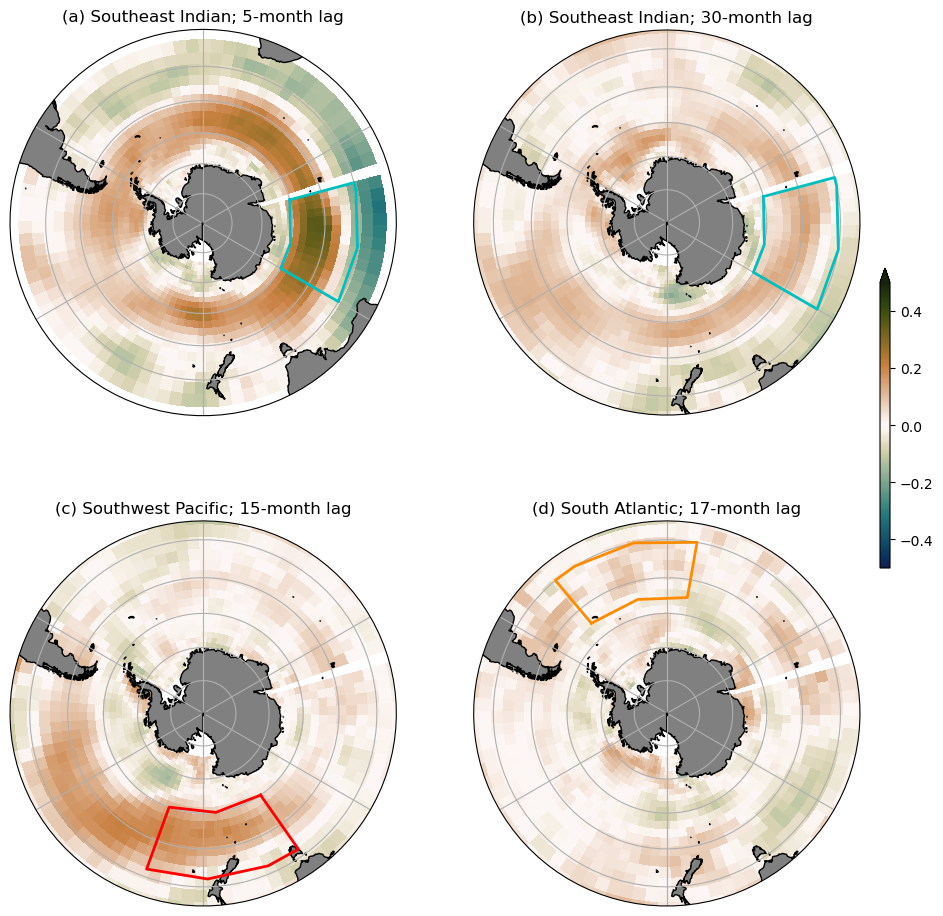

In [42]:
%%time
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(2,2,1,projection=ccrs.SouthPolarStereo())
ax2 = plt.subplot(2,2,2,projection=ccrs.SouthPolarStereo())
ax3 = plt.subplot(2,2,3,projection=ccrs.SouthPolarStereo())
ax4 = plt.subplot(2,2,4,projection=ccrs.SouthPolarStereo())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.add_feature(land_50m)
ax1.gridlines()
p1=ax1.pcolor(tau_deseas.lon, tau_deseas.lat, corr_mat_SEIO_5, vmin=-0.5, vmax=0.5,cmap=cm.cm.tarn_r,transform=ccrs.PlateCarree())
ax1.plot([SEIO['lon1'], SEIO['lon2'], SEIO['lon2'], SEIO['lon1'], SEIO['lon1']],
          [SEIO['lat1'],SEIO['lat1'],SEIO['lat2'],SEIO['lat2'],SEIO['lat1']],
         color='c',linewidth=2,transform=ccrs.PlateCarree())
ax1.set_title('(a) Southeast Indian; 5-month lag')

ax2.set_extent([-287, 73, -80, -35], crs=ccrs.PlateCarree())
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.add_feature(land_50m)
ax2.gridlines()
p2=ax2.pcolor(tau_deseas.lon, tau_deseas.lat, corr_mat_SEIO_30, vmin=-0.5, vmax=0.5,cmap=cm.cm.tarn_r,transform=ccrs.PlateCarree())
ax2.plot([SEIO['lon1'], SEIO['lon2'], SEIO['lon2'], SEIO['lon1'], SEIO['lon1']],
          [SEIO['lat1'],SEIO['lat1'],SEIO['lat2'],SEIO['lat2'],SEIO['lat1']],
         color='c',linewidth=2,transform=ccrs.PlateCarree())
ax2.set_title('(b) Southeast Indian; 30-month lag')

ax3.set_extent([-287, 73, -80, -35], crs=ccrs.PlateCarree())
ax3.set_boundary(circle, transform=ax3.transAxes)
ax3.add_feature(land_50m)
ax3.gridlines()
p3=ax3.pcolor(tau_deseas.lon, tau_deseas.lat, corr_mat_SWPO_15, vmin=-0.5, vmax=0.5,cmap=cm.cm.tarn_r,transform=ccrs.PlateCarree())
ax3.plot([SWPO['lon1'], SWPO['lon2'], SWPO['lon2'], SWPO['lon1'], SWPO['lon1']],
          [SWPO['lat1'],SWPO['lat1'],SWPO['lat2'],SWPO['lat2'],SWPO['lat1']],
         color='r',linewidth=2,transform=ccrs.PlateCarree())
ax3.set_title('(c) Southwest Pacific; 15-month lag')

ax4.set_extent([-287, 73, -80, -35], crs=ccrs.PlateCarree())
ax4.set_boundary(circle, transform=ax4.transAxes)
ax4.add_feature(land_50m)
ax4.gridlines()
p4=ax4.pcolor(tau_deseas.lon, tau_deseas.lat, corr_mat_SAO_17, vmin=-0.5, vmax=0.5,cmap=cm.cm.tarn_r,transform=ccrs.PlateCarree())
ax4.plot([SAO['lon1'], SAO['lon2'], SAO['lon2'], SAO['lon1'], SAO['lon1']],
          [SAO['lat1'],SAO['lat1'],SAO['lat2'],SAO['lat2'],SAO['lat1']],
         color='darkorange',linewidth=2,transform=ccrs.PlateCarree())
ax4.set_title('(d) South Atlantic; 17-month lag')

plt.subplots_adjust(left=0.05, bottom=0.05, top=0.95, right = 0.9)

ax_c = plt.axes([0.92,0.4,0.01,0.3])
plt.colorbar(p1,cax=ax_c,orientation='vertical',extend='max')

plt.savefig('/g/data/x77/amh157/OCCIPUT-analysis/paper/figures/Figure5.png',dpi=200)